---
<h1 align="center"><strong>Semantic Similarity CamemBERT</strong><h1>
<h1 align="center">---Similar / Not similar---<h1>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.2 MB 4.4 MB/s 
     |████████████████████████████████| 596 kB 36.8 MB/s 
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 35.5 MB/s 
     |████████████████████████████████| 1.2 MB 9.4 MB/s 
     |████████████████████████████████| 346 kB 7.7 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 212 kB 50.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.7 MB/s 
     |████████████████████████████████| 140 kB 53.4 MB/s 
     |████████████████████████████████| 127 kB 49.9 MB/s 
     |████████████████████████████████| 271 kB 51.5 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 49.6 MB/s 
     |████████████████████████████████| 112 kB 53.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  df = pd.concat([train_samples, dev_samples, test_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.7 else 0)
  return df

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


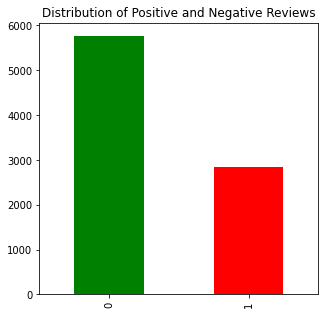

In [ ]:
df = pd.read_csv("sts.csv")

df["similarity_score"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

In [ ]:
class Config:
  MAX_LEN = 64
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_PATH = "stscamembertModel.bin"
  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())
    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Cross Model

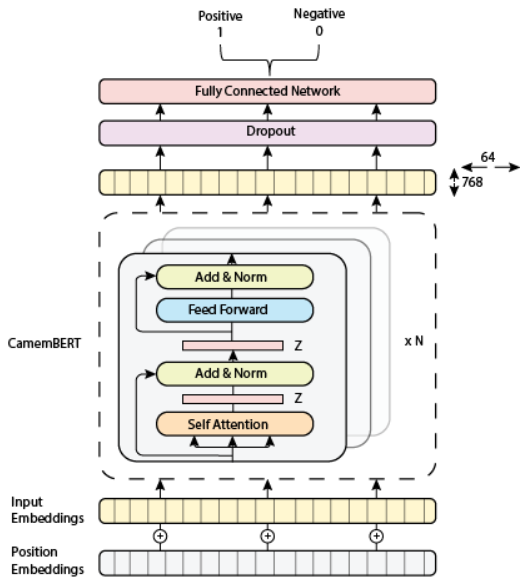

In [ ]:
class CamemBERTModel(nn.Module):
  def __init__(self):
    super(CamemBERTModel, self).__init__()
    self.camembert = Config.MODEL
    self.camembert_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    rbo = self.camembert_drop(pooled_output)
    output = self.out(rbo)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")

df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.1, random_state=42, stratify=dfx.similarity_score.values
    )

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = CamemBERTModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

### Error Analysis & Performance auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.8493626882966396
Recall Score    : 0.7157894736842105
Precision Score : 0.8063241106719368
F1 Score        : 0.758364312267658

Classification report 

               precision    recall  f1-score   support

         0.0       0.87      0.92      0.89       578
         1.0       0.81      0.72      0.76       285

    accuracy                           0.85       863
   macro avg       0.84      0.82      0.82       863
weighted avg       0.85      0.85      0.85       863



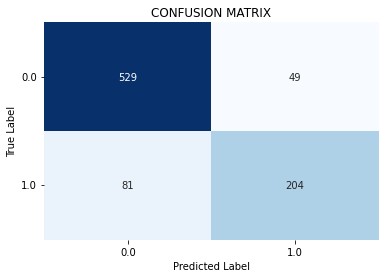

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

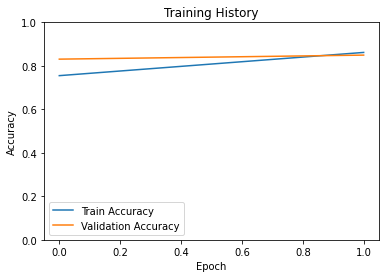

In [ ]:
plt.plot(history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Valid Accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

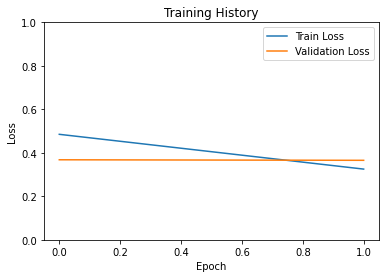

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = CamemBERTModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask) 
  similarity_Score = data.preprocess_output(outputs)
  no_similarity_Score = 1 - similarity_Score
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_Score),
      "no similarity Score": str(no_similarity_Score),
  }

In [ ]:
df

,Unnamed: 0,sentence1,sentence2,similarity_score
0,0,Un avion est en train de décoller.,Un avion est en train de décoller.,1
1,1,Un homme joue d'une grande flûte.,Un homme joue de la flûte.,1
2,2,Un homme étale du fromage râpé sur une pizza.,Un homme étale du fromage râpé sur une pizza n...,1
3,3,Trois hommes jouent aux échecs.,Deux hommes jouent aux échecs.,0
4,4,Un homme joue du violoncelle.,Un homme assis joue du violoncelle.,1
...,...,...,...,...
8623,8623,Les Philippines et le Canada s'engagent à renf...,Les Philippines en sauvent 100 après le naufra...,0
8624,8624,Israël interdit aux Palestiniens l'accès à la ...,"La solution à deux Etats entre Palestiniens, I...",0
8625,8625,Que savez-vous des services secrets ?,Les législateurs des deux parties expriment le...,0
8626,8626,Obama s'efforce d'apaiser les craintes des Sao...,Le Myanmar s'efforce de finaliser les listes é...,0


In [ ]:
sentence1 = "Un client content"
sentence2 = "le client n'est pas content"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'Un client content', 'sentence2': "le client n'est pas content", 'similarity Score': '0.9341371', 'no similarity Score': '0.06586289405822754'}


In [ ]:
similarity_score

{'no similarity Score': '0.06586289405822754',
 'sentence1': 'Un client content',
 'sentence2': "le client n'est pas content",
 'similarity Score': '0.9341371'}

### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**